In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt


In [2]:
level=7
fileidx=63

f=h5py.File('GadgetOutputs\level%d\snapshot_%03d.hdf5'%(level,fileidx),'r')
Loc=np.array(f['PartType1']['Coordinates'])
ParticleIDs=np.array(f['PartType1']['ParticleIDs'])
currentz=dict(f['Header'].attrs)['Redshift']
Ndim=int(np.cbrt(dict(f['Header'].attrs)['NumPart_Total'][1]))
celllen=dict(f['Header'].attrs)['BoxSize']/Ndim # length of a cell

In [3]:
# Lagrangian grid points
x = celllen*(0.5+np.arange(Ndim))
xg = np.meshgrid(x,x,x, indexing='ij')
xl = np.ravel(xg[0])
yl = np.ravel(xg[1])
zl = np.ravel(xg[2])
gridPoints=np.vstack([xl,yl,zl]).transpose()


#sort the particles according to ID
Loc_sorted=np.copy(Loc)
Loc_sorted[ParticleIDs]=Loc

#take care of the periodic boundary
delta=Loc_sorted - gridPoints
Loc_shifted=np.copy(Loc_sorted)
for dim in range(3):
    too_small = delta[:,dim] < -20.0
    too_big = delta[:,dim] > 20.0
    Loc_shifted[too_big,dim] -= 40.0
    Loc_shifted[too_small,dim] += 40.0

#displacement field Phi
Phi = Loc_shifted - gridPoints

#reshape into a 3d mesh so as to refer xid,yid,zid more easily
grid3d=np.stack(xg,axis=3)
Phi3d=np.reshape(Phi,(Ndim,Ndim,Ndim,3))

In [4]:
def get_tet_eigenvalues(Ndim,grid3d,Phi3d):
    ''' estimate eigenvalues of dPhi/dq at tetrahedra centers, by displacement fields on 4 vertices. 
        grid3d: particle's Lagrangian grid coordinates, of shape (Ndim+1,Ndim+1,Nim+1,3)
        Phi3d: displacment field, of shape (Ndim+1,Ndim+1,Nim+1,3)
        return eigenvalues: 3 eigenvalues of dPhi/dq at tetrahedra centers, of shape (Np*Ntetpp,3)  '''
    
    vert = np.array(( (0,0,0), (0,0,1), (0,1,0), (0,1,1), (1,0,0), (1,0,1), (1,1,0), (1,1,1) ))
    conn = np.array( ( (1,0,2,4), (3,1,2,4), (3,5,1,4), (3,6,5,4), (3,2,6,4), (3,7,5,6) ))
    Ntetpp = len(conn)
    Np = Ndim*Ndim*Ndim
    dPhidq=np.zeros((Np*Ntetpp,3,3))
    for m in range(Ntetpp):
        off = vert[conn[m]]
        P=np.zeros((Np,3,4)) # coordinates of 4 vertices
        myPhi=np.zeros((Np,3,4)) # displacement fields on 4 vertices
        P[:,:,0]    =np.reshape(grid3d[off[0][0]:(Ndim+off[0][0]),off[0][1]:(Ndim+off[0][1]),off[0][2]:(Ndim+off[0][2]), :],(Np,3))
        P[:,:,1]    =np.reshape(grid3d[off[1][0]:(Ndim+off[1][0]),off[1][1]:(Ndim+off[1][1]),off[1][2]:(Ndim+off[1][2]), :],(Np,3))
        P[:,:,2]    =np.reshape(grid3d[off[2][0]:(Ndim+off[2][0]),off[2][1]:(Ndim+off[2][1]),off[2][2]:(Ndim+off[2][2]), :],(Np,3))
        P[:,:,3]    =np.reshape(grid3d[off[3][0]:(Ndim+off[3][0]),off[3][1]:(Ndim+off[3][1]),off[3][2]:(Ndim+off[3][2]), :],(Np,3))
        myPhi[:,:,0]=np.reshape(Phi3d[off[0][0]:(Ndim+off[0][0]),off[0][1]:(Ndim+off[0][1]),off[0][2]:(Ndim+off[0][2]), :] ,(Np,3))
        myPhi[:,:,1]=np.reshape(Phi3d[off[1][0]:(Ndim+off[1][0]),off[1][1]:(Ndim+off[1][1]),off[1][2]:(Ndim+off[1][2]), :] ,(Np,3))
        myPhi[:,:,2]=np.reshape(Phi3d[off[2][0]:(Ndim+off[2][0]),off[2][1]:(Ndim+off[2][1]),off[2][2]:(Ndim+off[2][2]), :] ,(Np,3))
        myPhi[:,:,3]=np.reshape(Phi3d[off[3][0]:(Ndim+off[3][0]),off[3][1]:(Ndim+off[3][1]),off[3][2]:(Ndim+off[3][2]), :] ,(Np,3))
        center=(P[:,:,0]+P[:,:,1]+P[:,:,2]+P[:,:,3])/4
        centerPhi=(myPhi[:,:,0]+myPhi[:,:,1]+myPhi[:,:,2]+myPhi[:,:,3])/4   
        # dq from center to P[1],P[2],P[3]
        dq = np.zeros((Np,3,3))
        for i in [1,2,3]:
            for k in [1,2,3]:
                dq[:,i-1,k-1] = P[:,i-1,k] - center[:,i-1]
        # dPhi from center to P[1],P[2],P[3]
        deltaPhi = np.zeros((Np,3,3))
        for j in [1,2,3]:
            for k in [1,2,3]:
                deltaPhi [:,j-1,k-1] = myPhi[:,j-1,k] - centerPhi [:,j-1]
        dPhidq[m::Ntetpp,:,:] = np.matmul (deltaPhi,np.linalg.inv(dq)  )
    eigenvalues, eigenvectors = np.linalg.eig(dPhidq)
    return eigenvalues

Text(0.5, 1.0, 'z= 0.000000')

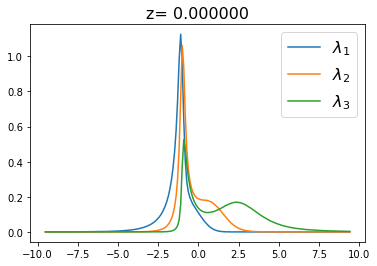

In [5]:
#get eigenvalues
eigenvalues = get_tet_eigenvalues(Ndim-1,grid3d,Phi3d)
Re_eigenvalues = np.real(eigenvalues)
Re_eigenvalues.sort(axis=1) # sort so that lamdba1<lambda2<lambda2

#get distribution
bin_range=5*np.std(Re_eigenvalues)
bin_disp=bin_range/100
tmp1=np.histogram(Re_eigenvalues[:,0],bins = np.arange(-bin_range,bin_range,bin_disp))
tmp2=np.histogram(Re_eigenvalues[:,1],bins = np.arange(-bin_range,bin_range,bin_disp))
tmp3=np.histogram(Re_eigenvalues[:,2],bins = np.arange(-bin_range,bin_range,bin_disp))

lambda_range=(tmp1[1][0:-1]+tmp1[1][1:len(tmp1[1])])/2
lambda1dist=tmp1[0]/np.trapz(tmp1[0],lambda_range) # normalized
lambda2dist=tmp2[0]/np.trapz(tmp2[0],lambda_range)
lambda3dist=tmp3[0]/np.trapz(tmp3[0],lambda_range) 

plt.plot(lambda_range,lambda1dist,label='$\\lambda_1$')
plt.plot(lambda_range,lambda2dist,label='$\\lambda_2$')
plt.plot(lambda_range,lambda3dist,label='$\\lambda_3$')
plt.legend(fontsize=16)
plt.title("z= %f"%currentz,fontsize=16)